In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import itertools
from scipy import stats

In [2]:
from statsmodels.stats.diagnostic import lillifors

In [3]:
data = pd.read_excel("/Users/FeatureForest/Documents/Spektra list gatunków Fritillaria.xlsx", sheet_name='DANE KWIATÓW', delimiter=";", decimal=",")

In [4]:
data.head()

,Gatunek,Kolor,Średnica,płatek
0,F. affinis,PUR,26.1,22.86
1,F. affinis,PUR,NaN,24.29
2,F. affinis,PUR,NaN,25.00
3,F. affinis,PUR,NaN,25.00
4,F. affinis,PUR,NaN,23.16


In [5]:
#retruns pollinator
def pollinator(name):
    if((name == 'F. eduardii') | (name == 'F. imperialis')):
        return "PAS"
    elif ((name == "F. recurva") | (name == "F. gentneri")):
        return "HUM"
    else:
        return "INS"

In [6]:
data.head()

,Gatunek,Kolor,Średnica,płatek
0,F. affinis,PUR,26.1,22.86
1,F. affinis,PUR,NaN,24.29
2,F. affinis,PUR,NaN,25.00
3,F. affinis,PUR,NaN,25.00
4,F. affinis,PUR,NaN,23.16


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 4 columns):
Gatunek     1606 non-null object
Kolor       1606 non-null object
Średnica    206 non-null float64
płatek      1146 non-null float64
dtypes: float64(2), object(2)
memory usage: 50.3+ KB


In [8]:
data.Gatunek.unique()

array(['F. affinis', 'F. caucasica', 'F. crassifolia', 'F. eastwoodiae',
       'F. eduardii', 'F. gibbosa', 'F. gracilis', 'F. graeca',
       'F. imperialis', 'F. kotschyana', 'F. latakiensis', 'F. liliae',
       'F. michailovskyi', 'F. meleagroides', 'F. montana',
       'F. mutabilis', 'F. pyrenaica', 'F. pontica', 'F. raddeana',
       'F. serpenticola', 'F. sewerzowii', 'F. stenanthera',
       'F. tubiformis', 'F. ussuriensis', 'F. uva vulpis',
       'F. whittallii', 'F. recurva', 'F. gentneri', 'F. ariana',
       'F. dasyphylla', 'F. minima', 'F. thunbergii', 'F. armena '],
      dtype=object)

In [9]:
#data["płatek"] = data.płatek.astype(float)


In [10]:
data.groupby(['Gatunek']).agg({'płatek': 'count'
                                }).reset_index()

,Gatunek,płatek
0,F. affinis,6
1,F. ariana,7
2,F. armena,6
3,F. caucasica,18
4,F. crassifolia,12
5,F. dasyphylla,6
6,F. eastwoodiae,6
7,F. eduardii,45
8,F. gentneri,85
9,F. gibbosa,6


In [11]:
df1 = data.groupby(['Gatunek']).agg({'Średnica': 'mean', 
                                     'płatek': 'mean'
                                }).reset_index()


In [12]:
df1.dropna(inplace=True)

In [13]:
df1['Pollinator'] = df1['Gatunek'].apply(pollinator)

In [14]:
df1

,Gatunek,Średnica,płatek,Pollinator
0,F. affinis,26.100000,23.960000,INS
1,F. ariana,26.390000,15.281429,INS
2,F. armena,10.000000,19.566667,INS
3,F. caucasica,27.930000,38.743889,INS
4,F. crassifolia,20.000000,15.772500,INS
5,F. dasyphylla,13.490000,15.013333,INS
6,F. eastwoodiae,17.000000,20.283333,INS
7,F. eduardii,79.786250,52.871778,PAS
8,F. gentneri,25.582667,28.630353,HUM
9,F. gibbosa,27.400000,15.116667,INS


In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 32
Data columns (total 4 columns):
Gatunek       33 non-null object
Średnica      33 non-null float64
płatek        33 non-null float64
Pollinator    33 non-null object
dtypes: float64(2), object(2)
memory usage: 1.3+ KB


In [16]:
ins_srednica = df1.Średnica[df1.Pollinator == "INS"]
pas_srednica = df1.Średnica[df1.Pollinator == "PAS"]
hum_srednica = df1.Średnica[df1.Pollinator == "HUM"]

### Testing normality srednica

In [17]:
pVals = pd.Series()
# The scipy normaltest is based on D-Agostino and Pearsons test that
# combines skew and kurtosis to produce an omnibus test of normality.
_, pVals['Omnibus']    = stats.normaltest(ins_srednica)

# Shapiro-Wilk test
_, pVals['Shapiro-Wilk']    = stats.shapiro(ins_srednica)

# Or you can check for normality with Lilliefors-test
_, pVals['Lilliefors']    = lillifors(ins_srednica)

# Alternatively with original Kolmogorov-Smirnov test
_, pVals['Kolmogorov-Smirnov']    = stats.kstest((ins_srednica-np.mean(ins_srednica))/np.std(ins_srednica,ddof=1), 'norm')

print('p-values for all {0} data points: ----------------'.format(len(ins_srednica)))
print(pVals)

if pVals['Omnibus'] > 0.05:
    print('Data are normally distributed')

p-values for all 29 data points: ----------------
Omnibus               0.015539
Shapiro-Wilk          0.023282
Lilliefors            0.200000
Kolmogorov-Smirnov    0.806033
dtype: float64


/Users/FeatureForest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `lillifors` is deprecated, use `lilliefors` instead!
Use lilliefors, lillifors will be removed in 0.9 
(Note: misspelling missing 'e')
  # Remove the CWD from sys.path while we load stuff.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from statsmodels.stats.libqsturng import psturng

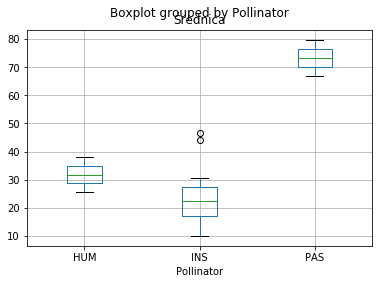

In [19]:
df1.boxplot('Średnica', by='Pollinator')

In [20]:
# First, check if the variances are equal, with the "Levene"-test
(W,p) = stats.levene(ins_srednica, pas_srednica, hum_srednica)
if p<0.05:
    print(('Warning: the p-value of the Levene test is <0.05: p={0}'.format(p)))
else:
    
    print('OK', p)

OK 0.9961632617596949


In [21]:
f, p = stats.f_oneway(ins_srednica,
                      hum_srednica,
                      pas_srednica)
 
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 33.36121306994132
P value: 2.3654354239800988e-08 



In [22]:
#Then, do the multiple testing
multiComp = MultiComparison(df1['Średnica'], df1['Pollinator'])

In [23]:
print((multiComp.tukeyhsd().summary()))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 HUM    INS   -8.5208  -23.7059  6.6643 False 
 HUM    PAS   41.5239  20.7532  62.2946  True 
 INS    PAS   50.0446  34.8595  65.2297  True 
----------------------------------------------


In [24]:
ins_płatek = df1.płatek[df1.Pollinator == "INS"]
pas_płatek = df1.płatek[df1.Pollinator == "PAS"]
hum_płatek = df1.płatek[df1.Pollinator == "HUM"]

In [25]:
# First, check if the variances are equal, with the "Levene"-test
(W,p) = stats.levene(ins_płatek, pas_płatek, hum_płatek)
if p<0.05:
    print(('Warning: the p-value of the Levene test is <0.05: p={0}'.format(p)))
else:
    
    print('OK', p)

OK 0.2821635786287848


In [26]:
f, p = stats.f_oneway(ins_płatek,
                      hum_płatek,
                      pas_płatek)
 
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 10.41567406430666
P value: 0.00036715073351564965 



In [27]:
#Then, do the multiple testing
multiComp = MultiComparison(df1['płatek'], df1['Pollinator'])

In [28]:
print((multiComp.tukeyhsd().summary()))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 HUM    INS   -8.4986  -24.3706  7.3735 False 
 HUM    PAS   20.1271  -1.5833  41.8374 False 
 INS    PAS   28.6256  12.7536  44.4977  True 
----------------------------------------------


In [29]:
df1[df1.Pollinator=='PAS']

,Gatunek,Średnica,płatek,Pollinator
7,F. eduardii,79.786250,52.871778,PAS
12,F. imperialis,66.884167,52.026739,PAS


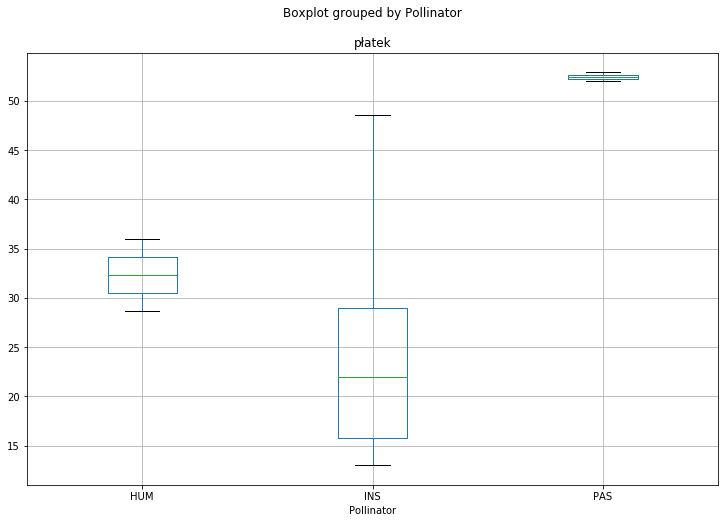

In [30]:
#Create a boxplot
df1.boxplot('płatek', by='Pollinator', figsize=(12, 8))

In [31]:
grub = pd.read_excel("/Users/FeatureForest/Documents/Spektra list gatunków Fritillaria.xlsx", sheet_name='grubość płatka', delimiter=";", decimal=",")

In [32]:
grub.drop(grub.columns[1:23], axis=1, inplace=True)

In [33]:
grub.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 38 entries, 1.0 to 37.0
Data columns (total 4 columns):
sp             38 non-null object
μm             38 non-null float64
sd             38 non-null float64
Unnamed: 25    38 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.5+ KB


In [34]:
grub.rename(index=str, columns={"μm": "grub", "Unnamed: 25": "N"}, inplace=True)

In [35]:
grub.reset_index(inplace=True)

In [36]:
grub.drop(grub.columns[0], axis=1, inplace=True)

In [37]:
grub.head()

,sp,grub,sd,N
0,F. affinis,504.600000,49.106415,5
1,F. amana,300.675926,19.680200,4
2,F. armena,620.500218,22.242582,5
3,F. ariana,427.061799,57.074561,7
4,F. aurea,714.772407,107.565515,8


In [38]:
xls = pd.ExcelFile('/Users/FeatureForest/Documents/Fritillaria Warsaw.xlsx')

In [39]:
names = xls.sheet_names

In [40]:
#list of analysed species
species = ["F. imperialis","F. michailovskyi",'F. whittallii','F. tubiformis','F. gracilis',
           'F. eduardii','F. minima','F. thunbergii','F. eastwoodiae', "F. liliaceae", 
           "F. liliaceae", "F. kurdica",'F. pyrenaica', 'F. pontica', 'F. thunbergii',
           'F. uva vulpis', 'F. affinis','F. montana',  'F. aryiana', 'F. dasyphylla', 
           'F. verticillata','F. serpenticola', 'F. mutabilis', 'F. raddeana', 'F. graeca', 
           'F. caucasica', 'F. gibbosa', 'F. armena','F. stenanthera','F. ussuriensis',
           'F. kotschyana','F. meleagris', "F. michailovskyi", 'F. latakesis', 'F. gentneri',
          'F. recurva', 'F. sewerzowii']

In [41]:
import re

In [42]:
outside = []
pattern = ".+ou.+"
outside = [x for x in names if re.match(pattern,x)]

In [43]:
#removing reflectance in other than red
indexes = [1,3,15,17,20,35,39,40]
for index in sorted(indexes, reverse=True):
    del outside[index]

In [44]:
#outside

In [45]:
indexes_outside = []
for i in range(len(outside)):
    indexes_outside.append(names.index(outside[i]))

sheets_outside = []
for i in range(len(outside)):
    sheet = xls.parse(indexes_outside[i])
    sheets_outside.append(sheet)

In [46]:
#returns UV & visible spectrum
for i in range(len(sheets_outside)):
    sheets_outside[i] = sheets_outside[i][(sheets_outside[i].nm > 300) & (sheets_outside[i].nm < 700)]

In [47]:
#columns wiht reflectancy value
columns_ref = sheets_outside[0].columns[1::2]

In [48]:
#returns mean of wavelengths (relative)
for i in range(len(sheets_outside)):
    sheets_outside[i] = sheets_outside[i].assign(mean=sheets_outside[i][columns_ref].mean(axis=1)/1000)

In [49]:
from functools import reduce

In [50]:
numbers = []
for i in range(1,38):
    numbers.append("Sp"+str(i))
nms = list(zip(numbers, species))
outside_species = []
for i in range(9):
    outside_species.append(reduce(lambda a, kv: a.replace(*kv), nms, outside[i])) 

In [51]:
for i in range(9, len(outside)):
    outside_species.append(reduce(lambda a, kv: a.replace(*kv), nms[9:], outside[i])) 

In [52]:
#sheets_outside[0]

In [53]:
#(outside_species)

In [54]:
len(species)

37

In [55]:
srednia = []
for i in range(len(sheets_outside)):
    srednia.append(sheets_outside[i]['mean'].mean())

In [56]:
len(srednia)

37

In [57]:
#srednia

In [58]:
reflektancja = pd.DataFrame(
    {'Gatunek': species,
     'srednia': srednia
    })

In [59]:
#reflektancja

In [60]:
grub

,sp,grub,sd,N
0,F. affinis,504.600000,49.106415,5
1,F. amana,300.675926,19.680200,4
2,F. armena,620.500218,22.242582,5
3,F. ariana,427.061799,57.074561,7
4,F. aurea,714.772407,107.565515,8
5,F. caucasica,632.798222,76.771188,10
6,F. dasyphylla,557.800000,45.004000,5
7,F. eastwoodiae,463.812778,47.375421,8
8,F. eduardii,964.971287,134.963390,19
9,F. gentneri,543.723148,140.982127,8


In [61]:
df = pd.merge(reflektancja, grub, how='inner', left_on='Gatunek', right_on='sp')

In [62]:
df

,Gatunek,srednia,sp,grub,sd,N
0,F. imperialis,36.742887,F. imperialis,856.232222,117.473314,9
1,F. michailovskyi,13.053858,F. michailovskyi,383.140741,19.799688,5
2,F. michailovskyi,3.391066,F. michailovskyi,383.140741,19.799688,5
3,F. whittallii,3.288491,F. whittallii,763.310588,74.625613,8
4,F. tubiformis,22.353346,F. tubiformis,678.394099,99.552051,7
5,F. gracilis,11.291390,F. gracilis,513.899290,98.215369,12
6,F. eduardii,12.215779,F. eduardii,964.971287,134.963390,19
7,F. minima,26.406632,F. minima,438.770370,33.114669,5
8,F. thunbergii,15.297238,F. thunbergii,470.000000,0.000000,1
9,F. thunbergii,11.317872,F. thunbergii,470.000000,0.000000,1


In [63]:
df['srednia'].corr(df['grub'])

0.08368340859752459

In [64]:
#retruns pollinator
def pollinator(name):
    if((name == 'F. eduardii') | (name == 'F. imperialis')):
        return "PAS"
    elif ((name == "F. recurva") | (name == "F. gentneri")):
        return "HUM"
    else:
        return "INS"

In [65]:
df['Pollinator'] = df['Gatunek'].apply(pollinator)

In [66]:
df

,Gatunek,srednia,sp,grub,sd,N,Pollinator
0,F. imperialis,36.742887,F. imperialis,856.232222,117.473314,9,PAS
1,F. michailovskyi,13.053858,F. michailovskyi,383.140741,19.799688,5,INS
2,F. michailovskyi,3.391066,F. michailovskyi,383.140741,19.799688,5,INS
3,F. whittallii,3.288491,F. whittallii,763.310588,74.625613,8,INS
4,F. tubiformis,22.353346,F. tubiformis,678.394099,99.552051,7,INS
5,F. gracilis,11.291390,F. gracilis,513.899290,98.215369,12,INS
6,F. eduardii,12.215779,F. eduardii,964.971287,134.963390,19,PAS
7,F. minima,26.406632,F. minima,438.770370,33.114669,5,INS
8,F. thunbergii,15.297238,F. thunbergii,470.000000,0.000000,1,INS
9,F. thunbergii,11.317872,F. thunbergii,470.000000,0.000000,1,INS


In [67]:
ins = df[df.Pollinator == "INS"]

In [68]:
ins['srednia'].corr(ins['grub'])

0.01962966684566265

In [69]:
hum = df[df.Pollinator == "HUM"]

In [70]:
hum['srednia'].corr(hum['grub'])

1.0

In [71]:
pas = df[df.Pollinator == "PAS"]
pas['srednia'].corr(pas['grub'])

-1.0

In [72]:
df = pd.merge(df1, grub, how='inner', left_on='Gatunek', right_on='sp')

In [73]:
df1.Gatunek.unique()

array(['F. affinis', 'F. ariana', 'F. armena ', 'F. caucasica',
       'F. crassifolia', 'F. dasyphylla', 'F. eastwoodiae', 'F. eduardii',
       'F. gentneri', 'F. gibbosa', 'F. gracilis', 'F. graeca',
       'F. imperialis', 'F. kotschyana', 'F. latakiensis', 'F. liliae',
       'F. meleagroides', 'F. michailovskyi', 'F. minima', 'F. montana',
       'F. mutabilis', 'F. pontica', 'F. pyrenaica', 'F. raddeana',
       'F. recurva', 'F. serpenticola', 'F. sewerzowii', 'F. stenanthera',
       'F. thunbergii', 'F. tubiformis', 'F. ussuriensis',
       'F. uva vulpis', 'F. whittallii'], dtype=object)

In [74]:
grub.sp.unique()

array(['F. affinis', 'F. amana', 'F. armena', 'F. ariana', 'F. aurea',
       'F. caucasica', 'F. dasyphylla', 'F. eastwoodiae', 'F. eduardii',
       'F. gentneri', 'F. gibbosa', 'F. gracilis', 'F. graeca',
       'F. imperialis', 'F. kotschyana', 'F. crassifolia',
       'F. latakiensis', 'F. liliaceae', 'F. meleagris',
       'F. michailovskyi', 'F. minima', 'F. minuta', 'F. montana',
       'F. mutabilis', 'F. persica', 'F. pontica', 'F. pyrenaica',
       'F. raddeana', 'F. recurva', 'F. serpenticola', 'F. sewerzowii',
       'F. stenanthera', 'F. thunbergii', 'F. tubiformis',
       'F. ussuriensis', 'F. uva vulpis', 'F. verticillata',
       'F. whittallii'], dtype=object)

In [75]:
df

,Gatunek,Średnica,płatek,Pollinator,sp,grub,sd,N
0,F. affinis,26.100000,23.960000,INS,F. affinis,504.600000,49.106415,5
1,F. ariana,26.390000,15.281429,INS,F. ariana,427.061799,57.074561,7
2,F. caucasica,27.930000,38.743889,INS,F. caucasica,632.798222,76.771188,10
3,F. crassifolia,20.000000,15.772500,INS,F. crassifolia,459.110000,52.165361,9
4,F. dasyphylla,13.490000,15.013333,INS,F. dasyphylla,557.800000,45.004000,5
5,F. eastwoodiae,17.000000,20.283333,INS,F. eastwoodiae,463.812778,47.375421,8
6,F. eduardii,79.786250,52.871778,PAS,F. eduardii,964.971287,134.963390,19
7,F. gentneri,25.582667,28.630353,HUM,F. gentneri,543.723148,140.982127,8
8,F. gibbosa,27.400000,15.116667,INS,F. gibbosa,515.056667,126.166533,6
9,F. gracilis,24.900000,24.038333,INS,F. gracilis,513.899290,98.215369,12


In [76]:
col = {'INS':'#FFE125', 'PAS':'#007800', 'HUM':'#bf0000'}
df["colors"] = df.Pollinator.apply(lambda x: col[x])

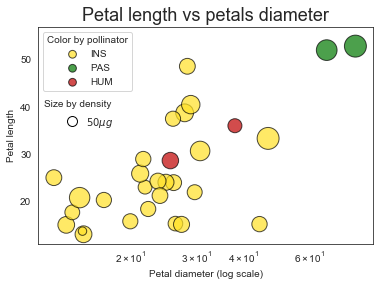

In [77]:
labels =[]
sns.set_style("white")
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = df.Średnica[df.Pollinator == key], y = df.płatek[df.Pollinator == key],
            s = np.array(df.grub[df.Pollinator == key])/2, 
            c = df.colors[df.Pollinator == key], alpha=0.7, edgecolors='black')

#plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Petal diameter (log scale)')
plt.ylabel('Petal length')
plt.title('Petal length vs petals diameter', fontsize=18)
#plt.xlim(0,350)

#plt.xticks([1000,10000,100000], ['1k','10k','100k'])
#plt.text(120, 24, 'F.imperialis')
#plt.text(70, 4, 'F.eduardi')
lgnd = plt.legend(labels, title='Color by pollinator')
for i in range(len(col)):
    lgnd.legendHandles[i]._sizes = [60]

plt.text(11.8,40, "Size by density")
plt.scatter(14, 37, s=100, c = 'white', edgecolors='k')
plt.text(15.2, 36,  r'$50 \mu g$')
# Show the plot
plt.show()